In [ ]:
"""
Dedalus script for 3D, rotating quasistatic magnetohydrodynamics (QMHD). 
This regime is valid in the limit of low magnetic Reynolds number and 
a strong uniform, background mangetic field.
This script uses a Fourier basis in all directions with periodic boundary
conditions.  
"""

import numpy as np
import h5py
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

import time
import pathlib
from dedalus import public as de
from dedalus.extras import flow_tools

import logging
logger = logging.getLogger(__name__)

ncores = comm.Get_size()
nnodes = int(ncores/16)
logger.info('Running on %s cores,  %s nodes' % (ncores,nnodes))

from params import *

from fractional_laplacian import FractionalLaplacian

#############################
# DEFINITIONS AND OPERATORS #
#############################
import spec1d
import flux1d
import nonlin_term
import vector_cal as vc

# Add operator to namespace
de.operators.parseables['FractionalLaplacian'] = FractionalLaplacian

In [1]:
import matplotlib.pyplot as plt

# Define domain

In [6]:
##########
# DOMAIN #
##########

# Create bases and domain
x_basis = de.Fourier('x', Nx, interval=(0, Lx), dealias=3/2)
y_basis = de.Fourier('y', Ny, interval=(0, Ly), dealias=3/2)

domain = de.Domain([x_basis, y_basis], grid_dtype=np.float64)#,mesh=(nnodes,16))

# For general use
x = domain.grid(0)
y = domain.grid(1)
X,Y = np.meshgrid(x,y)
kx = domain.elements(0)
ky = domain.elements(1)
k2 = kx**2 + ky**2

NameError: name 'de' is not defined

# Forcing

In [7]:
###########
# FORCING #
###########
# Initialize fields
Fp = domain.new_field() # Phi frocing
Ft = domain.new_field() # Tau forcing

# Forcing range
cond = (k2<=kf_max**2)&(k2>=kf_min**2)

local_coeff_shape=Fp['c'].shape
phase = np.random.uniform(low=-np.pi,high=np.pi,size=local_coeff_shape)
Fp['c'][cond] = (np.cos(phase[cond])+1j*np.sin(phase[cond]))/np.sqrt(k2[cond])  # Dividing by |k| because the curl will give velocity

local_coeff_shape=Ft['c'].shape
phase = np.random.uniform(low=-np.pi,high=np.pi,size=local_coeff_shape)
Ft['c'][cond] = (np.cos(phase[cond])+1j*np.sin(phase[cond]))/np.sqrt(k2[cond])

# Normalize:
KE_op = (Fp*Fp)/(Lx*Ly) # Calculating the volume average of |Fp|^2
KE_int_op = de.operators.integrate(KE_op,'x','y') 
E = KE_int_op.evaluate()['g'][0,0]
Fp['g'] = Fp['g']*fp0/np.sqrt(E)

KE_op = (Ft*Ft)/(Lx*Ly) # Calculating the volume average of |Fp|^2
KE_int_op = de.operators.integrate(KE_op,'x','y')
E = KE_int_op.evaluate()['g'][0,0]
Ft['g'] = Ft['g']*ft0/np.sqrt(E)

NameError: name 'domain' is not defined

In [8]:
plt.imshow(Fp['g'])

NameError: name 'Fp' is not defined

In [9]:
plt.imshow(Ft['g'])

NameError: name 'Ft' is not defined

In [10]:
##########################
# Other fields/functions #
##########################

# Height field
h = domain.new_field()
h['g'] = 0.0#Y

# Definition of r
def thresh_r(*args):
    #x   = args[0].data # this is an array; we use .data to get its values
    #y   = args[1].data
    w = args[0].data
    rtemp = args[1].value
#     print(type(w),type(rtemp),rtemp)
#     print('size of w is = ', w.shape)
#     print('value of r is = ', rtemp)
    
#     print(w[np.abs(w)>0])
#     plt.imshow(w)
#     plt.colorbar()
#     plt.title('w')
#     plt.show()
    
    R = np.copy(w)
    R[w>=0]= rtemp
    R[w<0] = 1
    
#     print(R[np.abs(R)>0])
#     plt.imshow(R)
#     plt.colorbar()
#     plt.title('R')
#     plt.show()
    
    return R

def Sthresh_r(*args, domain=domain, F=thresh_r):
    """This function takes arguments *args, a function F, and a domain and
    returns a Dedalus GeneralFunction that can be applied.

    """
    return de.operators.GeneralFunction(domain, layout='g', func=thresh_r, args=args)

# Make it parseable
de.operators.parseables['thresh_r'] = Sthresh_r

NameError: name 'domain' is not defined

In [11]:
plt.imshow(h['g'])

NameError: name 'h' is not defined

# Equations

In [12]:
#############
# EQUATIONS #
#############
problem = de.IVP(domain, variables=['phi','tau','w'])
# r value
problem.parameters['r'] = r
# Dissipation
problem.parameters['nu'] = nu
problem.substitutions['nn'] = "%f" % nn # Hyperviscosity exponent
# Forcing
problem.parameters['Fp'] = Fp
problem.parameters['Ft'] = Ft
# Other fields/functions
problem.parameters['h'] = h
# Operator substitutions
### Maybe we could define r here?
problem.substitutions['J(a,b)'] = "dx(a)*dy(b)-dy(a)*dx(b)"
problem.substitutions['Lap(a)'] = "dx(dx(a)) + dy(dy(a))"
problem.substitutions['FL'] = "FractionalLaplacian"
# Equtions of motion
#                     cfl           +  nu*k**2*nn              k^2*phi            k^2*tau^2/phi    tau h/phi
problem.add_equation("dt(Lap(phi)) + nu*FL(Lap(phi),nn)      = -J(phi,Lap(phi)) - J(tau,Lap(tau)) + J(tau,h) + Fp", condition="(nx != 0) or (ny != 0)")
problem.add_equation("dt(Lap(tau)) + nu*FL(Lap(tau),nn)  + w = -J(phi,Lap(tau)) - J(tau,Lap(phi)) + J(phi,h) + Fp", condition="(nx != 0) or (ny != 0)")
problem.add_equation(" Lap(w) - w  = Lap((1-thresh_r(w,r))*w) + 2*J(tau,Lap(phi)) - 2*J(dx(phi),dx(tau)) - 2*J(dy(phi),dy(tau)) - J(Lap(phi),h)", condition="(nx != 0) or (ny != 0)") #- 2*J(dx(phi),dx(tau)) - 2*J(dy(phi),dy(tau)) - J(Lap(phi),h)
problem.add_equation("phi = 0" , condition="(nx == 0) and (ny == 0)")
problem.add_equation("tau = 0" , condition="(nx == 0) and (ny == 0)")
problem.add_equation("w = 0" , condition="(nx == 0) and (ny == 0)")

# Build solver
solver = problem.build_solver(de.timesteppers.RK443)
#de.timesteppers.SBDF3)
#de.timesteppers.RK443)
#de.timesteppers.RK222)

logger.info('Solver built')

NameError: name 'de' is not defined

# Initial Conditions

In [7]:
#################################
# Initial conditions or restart #
#################################
if not pathlib.Path('restart.h5').exists():

    # Initial conditions
    phi = solver.state['phi']
    tau = solver.state['tau']
    w = solver.state['w']

    local_coeff_shape=w['g'].shape
    tau['g'] = NA*np.random.uniform(size=local_coeff_shape)
    phi['g'] = NA*np.random.uniform(size=local_coeff_shape)
    w['g'] = NA*np.random.uniform(size=local_coeff_shape)
    
    # Take away small-scale noise
    tau['c'][k2>20**2] = 0.0
    w['c'][k2>20**2] = 0.0
    phi['c'][k2>20**2] = 0.0

    # Timestepping and output
    dt = 1e-5 # Make initial guess (extra small, just in case)
    fh_mode = 'overwrite'
    
else:
    # Restart
    write, last_dt = solver.load_state('restart.h5', -1)

    # Timestepping and output
    dt = last_dt
    fh_mode = 'append'

# Integration parameters
solver.stop_sim_time = sim_tmax
solver.stop_wall_time = real_tmax

NameError: name 'pathlib' is not defined

In [8]:
plt.imshow(tau['g'])

NameError: name 'tau' is not defined

# CFL

In [9]:
#######
# CFL #
#######
CFL = flow_tools.CFL(solver, initial_dt=dt, safety=0.5, cadence=10, threshold=0.05)
CFL.add_velocities(('dx(phi)','dy(tau)'))

# Momentum diffusion
kcut = Nx/2. # not Nx/3 because of the 3/2 dealiasing rule instead of the 2/3 rule.
CFL.add_frequency(nu*kcut**(2*nn))

## ADD

logger.info('1/dt restriction from visc = %f' % (nu*kcut**(2*nn)))

NameError: name 'flow_tools' is not defined

In [10]:
############
# Analysis #
############
# SNAPSHOTS
snapshots = solver.evaluator.add_file_handler('snapshots', wall_dt=tsnap_wall, max_writes=50, mode=fh_mode)
snapshots.add_system(solver.state)
snapshots.add_task("Lap(phi)" ,name='zeta_bt')
snapshots.add_task("Lap(tau)" ,name='zeta_bc')

## TIME SERIES
#t_series = solver.evaluator.add_file_handler('time_series', iter=tseries,mode=fh_mode)
#t_series.add_task("integ(u*u+v*v+w*w)/2", name='en')
#t_series.add_task("integ(u*Fx+v*Fy+w*Fz)",name = 'inj')
#t_series.add_task("integ(u*nu*FL(u,nn)+v*nu*FL(v,nn)+w*nu*FL(w,nn))",name = 'diss')
#t_series.add_task("integ(u*hnu*FL(u,-mm)+v*hnu*FL(v,-mm)+w*hnu*FL(w,-mm))",name = 'hdiss')
#t_series.add_task("integ(u*BO(u) + v*BO(v) + w*BO(w))", name='bdiss')

# Flow properties # HELP: What is this exactly? What's the difference between flow properties and the tasks above?
flow = flow_tools.GlobalFlowProperty(solver, cadence=10)
flow.add_property("sqrt(dx(phi)**2 + dy(phi)**2 + dx(tau)**2 + dy(tau)**2 +w*w)", name='Re')
flow.add_property("(dx(phi)**2 + dy(phi)**2 + dx(tau)**2 + dy(tau)**2 +w*w)/2", name='KE')

NameError: name 'solver' is not defined

In [11]:
# Main loop
try:
    logger.info('Starting loop')
    start_time = time.time()
    while solver.proceed:
        dt = CFL.compute_dt()
        dt = solver.step(dt)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))
            logger.info('Max KE = %f' %flow.max('Re'))
            logger.info('KE = %f' %flow.volume_average('KE'))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
#     if rank==0:
#         f.close()
    end_time = time.time()
    logger.info('Iterations: %i' %solver.iteration)
    logger.info('Sim end time: %f' %solver.sim_time)
    logger.info('Run time: %.2f sec' %(end_time-start_time))
    logger.info('Run time: %f cpu-hr' %((end_time-start_time)/60/60*domain.dist.comm_cart.size))


NameError: name 'time' is not defined

In [12]:
phi = solver.state['phi']
w = solver.state['w']
tau = solver.state['tau']

NameError: name 'solver' is not defined

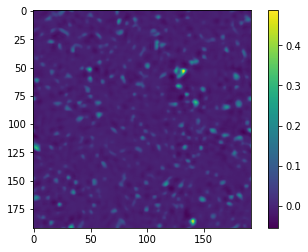

In [17]:
plt.imshow(w['g'])
plt.colorbar()

# Flux tests

# Define domain

In [3]:
# Add operator to namespace
de.operators.parseables['FractionalLaplacian'] = FractionalLaplacian

Lx = Ly = 2*np.pi
Nx = Ny = 512

# Create bases and domain
x_basis = de.Fourier('x', Nx, interval=(0, Lx), dealias=3/2)
y_basis = de.Fourier('y', Ny, interval=(0, Ly), dealias=3/2)

In [4]:
domain = de.Domain([x_basis, y_basis], grid_dtype=np.float64)

In [5]:
# For general use
x = domain.grid(0,scales=1)
y = domain.grid(1,scales=1)
kx = domain.elements(0)
ky = domain.elements(1)
k2 = kx**2 + ky**2

## Load data

In [6]:
import field_calc

In [7]:
psi_in = field_calc.field_calc('O5','ps','014')
vz_in = field_calc.field_calc('O5','vz','014')

# Initialize fields
psi = domain.new_field(scales=1)
vz = domain.new_field(scales=1)
psi['g'] = psi_in
vz['g'] = vz_in

In [8]:
np.shape(psi['g'])

(512, 512)

In [9]:
[u,v] = vc.curl(domain,[psi])
psi.set_scales(1)
u.set_scales(1)
v.set_scales(1)

In [10]:
np.shape(u['g'])

(512, 512)

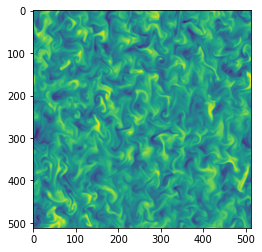

In [11]:
plt.imshow(vz['g'])

In [12]:
vort = FractionalLaplacian(psi,1)
vort =vort.evaluate()
vort.set_scales(1)
np.shape(vort['g'])

(512, 512)

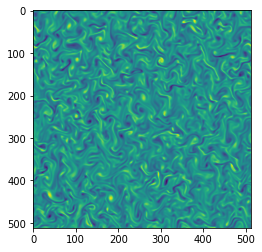

In [15]:
plt.imshow(vort['g'])

### Spectrum

In [13]:
import time

start = time.time()
[modn,Enk] = spec1d.spec1d(domain,[u,v])
[modn,Enkz] = spec1d.spec1d(domain,[vz])
end = time.time()
print('new',end-start)

start = time.time()
[modn2,Enk2] = spec1d.spec1d_classic(domain,[u,v])
[modn2,Enk2z] = spec1d.spec1d_classic(domain,[vz])
end = time.time()
print('classic',end-start)

new 0.09868741035461426
classic 0.5111205577850342


(1e-07, 1.1112892096573874)

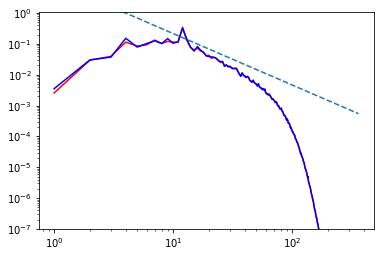

In [17]:
plt.loglog(modn,Enk+Enkz,'r')
# plt.loglog(modn,Enkz,'--r')
plt.loglog(modn2,Enk2+Enk2z,'b')
plt.loglog(modn,10*modn**(-5./3.),'--')
plt.ylim(1e-7,np.max(Enk)*5)

### Fluxes

We need to calculate the pressure here, making it incompressible

In [20]:
# Solve for the pressure
a = u*x_basis.Differentiate(u) + v*y_basis.Differentiate(u)
b = u*x_basis.Differentiate(v) + v*y_basis.Differentiate(v)
# c = u*x_basis.Differentiate(vz) + v*y_basis.Differentiate(vz)
p = -FractionalLaplacian(x_basis.Differentiate(a)+y_basis.Differentiate(b),-1)
p=p.evaluate()
p.set_scales(1)

In [21]:
# # Calculate nonlinear part:
# # problem.substitutions['Adv(a)'] = "u*dx(a) + v*dy(a)"
# a = -u*x_basis.Differentiate(u) -v*y_basis.Differentiate(u) -x_basis.Differentiate(p)
# b = -u*x_basis.Differentiate(v) -v*y_basis.Differentiate(v) -y_basis.Differentiate(p)

In [22]:
# a=a.evaluate()
# b=b.evaluate()
# # c=c.evaluate()

# a.set_scales(1)
# b.set_scales(1)
# # c.set_scales(1)
# u.set_scales(1)
# v.set_scales(1)

# # Divergence check
# divu = vc.div(domain,[a,b])

# div_int_op = de.operators.integrate(np.abs(divu)/(Lx*Ly),'x','y') 
# div = div_int_op.evaluate()['g'][0,0]
# print('divu',div)

In [23]:
# a.set_scales(1)
# b.set_scales(1)
# u.set_scales(1)
# v.set_scales(1)

In [24]:
import time

start = time.time()
a,b = nonlin_term.nonlin_term(domain,[u,v,p])
ns = nonlin_term.nonlin_term_scalar(domain,[u,v],vz)
end = time.time()
print('nonlin_calc',end-start)

start = time.time()
[modn,Enk] = flux1d.flux1d(domain,[u,v],[a,b],flux=True)
[modn_z,Enk_z] = flux1d.flux1d_scalar_classic(domain,vz,ns,flux=True)
end = time.time()
print('new',end-start)

start = time.time()
[modn2,Enk2] = flux1d.flux1d_classic(domain,[u,v],[a,b],flux=True)
[modn_z2,Enk_z2] = flux1d.flux1d_scalar_classic(domain,vz,ns,flux=True)
end = time.time()
print('classic',end-start)

nonlin_calc 0.29987478256225586
2020-12-07 14:43:33,395 flux1d 0/1 ERROR :: WARNING: You are using the version of the flux calculation which does not seem to conserve energy. Try using "flux1d_classic", which is about 8 times slower, but conserves the energy.
new 0.2789273262023926
classic 0.4812164306640625


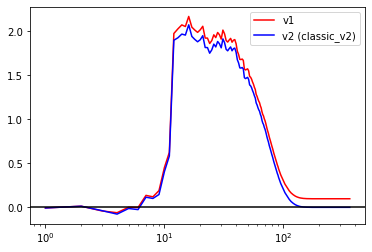

In [25]:
plt.semilogx(modn,Enk+Enk_z,'r',label='v1')
plt.semilogx(modn2,Enk2+Enk_z2,'b',label='v2 (classic_v2)')
plt.axhline(y=0,c='k')
plt.legend()
# plt.ylim(-1,1)

H5 file practice

In [100]:
f = h5py.File('test_flux_spec.h5','w')

In [101]:
spec = f.create_group('spectra')
flux = f.create_group('flux')

In [102]:
spec.create_dataset('time', data = [0.0],maxshape=(None,),chunks=True)
spec.create_dataset('modn',data=modn)
spec.create_dataset('KE',data=[Enk+Enkz],maxshape=(None,np.shape(Enk)[0]),chunks=True)

<HDF5 dataset "KE": shape (1, 361), type "<f8">

In [103]:
flux.create_dataset('time', data = [0.0],maxshape=(None,),chunks=True)
flux.create_dataset('modn',data=modn2)
flux.create_dataset('KE',data=[Enk2+Enk_z2],maxshape=(None,np.shape(Enk2)[0]),chunks=True)

<HDF5 dataset "KE": shape (1, 361), type "<f8">

In [104]:
flux['time']

<HDF5 dataset "time": shape (1,), type "<f8">

In [105]:
flux['time'].resize((flux['time'].shape[0] + 1), axis = 0)

In [106]:
flux['time'][-1:] = [0.1]

In [107]:
print(np.shape(flux['KE']))
flux['KE'].resize((flux['KE'].shape[0] + 1), axis = 0)
print(np.shape(flux['KE']))

(1, 361)
(2, 361)


In [108]:
flux['KE'][-1:] = [2*Enk2+2*Enk_z2]

In [113]:
flux['KE'][:].shape

(2, 361)

In [99]:
f.close()

Now test opening and appending file:

In [14]:
f = h5py.File('test_flux_spec.h5','a')

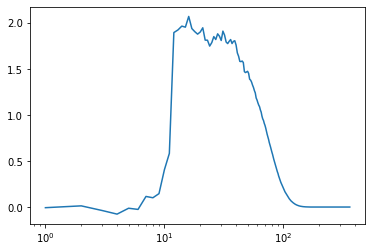

In [30]:
plt.semilogx(f['flux']['modn'][:],f['flux']['KE_1'][:])

In [31]:
spec = f['spectra']
flux = f['flux']

In [32]:
# spec.create_dataset('modn',data=modn)
spec.create_dataset('KE_%s' % 2,data=2*Enk+2*Enkz)

<HDF5 dataset "KE_2": shape (361,), type "<f8">

In [37]:
f['spectra'].keys()

<KeysViewHDF5 ['KE_1', 'KE_2', 'modn']>